In [1]:
import pandas as pd
import numpy as np
from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.utils import *
from sklearn.preprocessing import *


trainingSensor = pd.read_csv("E:/kimwoojae/AIGrowthModel/Eel/data/109.지능형 스마트양식장 이미지 데이터(뱀장어)/01.데이터/1.Training/원천데이터/1-66_스마트양식장_이미지(뱀장어)_Training_원천데이터/2_센서 데이터/1_자포니카/센서 측정값 데이터/sensor_val_tb.csv")
validationSensor = pd.read_csv("E:/kimwoojae/AIGrowthModel/Eel/data/109.지능형 스마트양식장 이미지 데이터(뱀장어)/01.데이터/2.Validation/원천데이터/1-66_스마트양식장_이미지(뱀장어)_Validation_원천데이터/2_센서 데이터/1_자포니카/센서 측정값 데이터/sensor_val_tb.csv")

trainingFood = pd.read_csv("E:/kimwoojae/AIGrowthModel/Eel/data/109.지능형 스마트양식장 이미지 데이터(뱀장어)/01.데이터/1.Training/원천데이터/1-66_스마트양식장_이미지(뱀장어)_Training_원천데이터/3_관리 데이터/1_자포니카/2_사료 공급관리 데이터/food_supply_tb.csv")
validationFood = pd.read_csv("E:/kimwoojae/AIGrowthModel/Eel/data/109.지능형 스마트양식장 이미지 데이터(뱀장어)/01.데이터/2.Validation/원천데이터/1-66_스마트양식장_이미지(뱀장어)_Validation_원천데이터/3_관리 데이터/1_자포니카/2_사료 공급관리 데이터/food_supply_tb.csv")

In [2]:
trainingSensor["mea_dt"] = trainingSensor["mea_dt"].apply(str)
trainingSensor["mea_dt"]  = trainingSensor["mea_dt"].str.slice(start=0, stop=15)
trainingFood['feed_dt'] = pd.to_datetime(trainingFood['feed_dt'], format='%Y%m%d%H%M', errors='raise')
trainingFood["feed_dt"]=trainingFood["feed_dt"].apply(str)
trainingFood["feed_dt"]  = trainingFood["feed_dt"].str.slice(start=0, stop=15)

validationSensor["mea_dt"] = validationSensor["mea_dt"].apply(str)
validationSensor["mea_dt"]  = validationSensor["mea_dt"].str.slice(start=0, stop=15)
validationFood['feed_dt'] = pd.to_datetime(validationFood['feed_dt'], format='%Y%m%d%H%M', errors='raise')
validationFood["feed_dt"] = validationFood["feed_dt"].apply(str)
validationFood["feed_dt"] = validationFood["feed_dt"].str.slice(start=0, stop=15)

In [3]:
training = pd.merge(left = trainingSensor, right = trainingFood, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
validation = pd.merge(left = validationSensor, right = validationFood, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
validation_oneday = pd.merge(left = validationSensor, right = validationFood, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

In [4]:
training = training[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
validation = validation[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
training = training.fillna(0)
validation = validation.fillna(0)

In [5]:
x_train = training[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
y_train = training[['do_mg']]
x_test = validation[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
y_test = validation[['do_mg']]

In [6]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
std_scaler.fit(x_train)
x_train_t = std_scaler.transform(x_train)
x_train = pd.DataFrame(x_train_t, columns=x_train.columns, index=list(x_train.index.values))

In [7]:
x_train = np.asarray(x_train, dtype=np.float64)
x_test = np.asarray(x_test, dtype=np.float64)

In [8]:
x_train.shape

(1113748, 8)

In [9]:
x_train = x_train.reshape((-1, 1, 8))
x_test = x_test.reshape((-1, 1, 8))
x_train.shape

(1113748, 1, 8)

In [10]:
# shape확인
nCar = x_train.shape[0] # 데이터 개수
nVar = x_train.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_train.shape[0] # 데이터 개수
nVar = y_train.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = x_test.shape[0] # 데이터 개수
nVar = x_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1113748 nVar: 1
nCar: 1113748 nVar: 1
nCar: 1113748 nVar: 1
nCar: 1113748 nVar: 1


In [11]:
#from keras import backend as K
#def r_squared(y_true, y_pred):
    #ss_res = K.sum(K.square(y_true - y_pred))
    #ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    #return (1 - ss_res/(ss_tot + K.epsilon()))

In [12]:
#model = Sequential()
#model.add(LSTM(128, input_shape=(1, 8), return_sequences=True))
#model.add(LSTM(64, return_sequences=True))
#model.add(LSTM(32))
#model.add(Dense(1, activation='linear'))
 
#model.summary()
 
# 3. 실행
#model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])

In [13]:
#hist = model.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data=(x_test, y_test))

In [14]:
#model.save('lstmJaponica3.h5')

In [15]:
from keras.models import load_model
model = load_model('lstmJaponica1.h5')

In [16]:
pred = model.predict(x_test)

pred.shape
 

34805/34805 [==============================] - 59s 2ms/step


(1113748, 1)

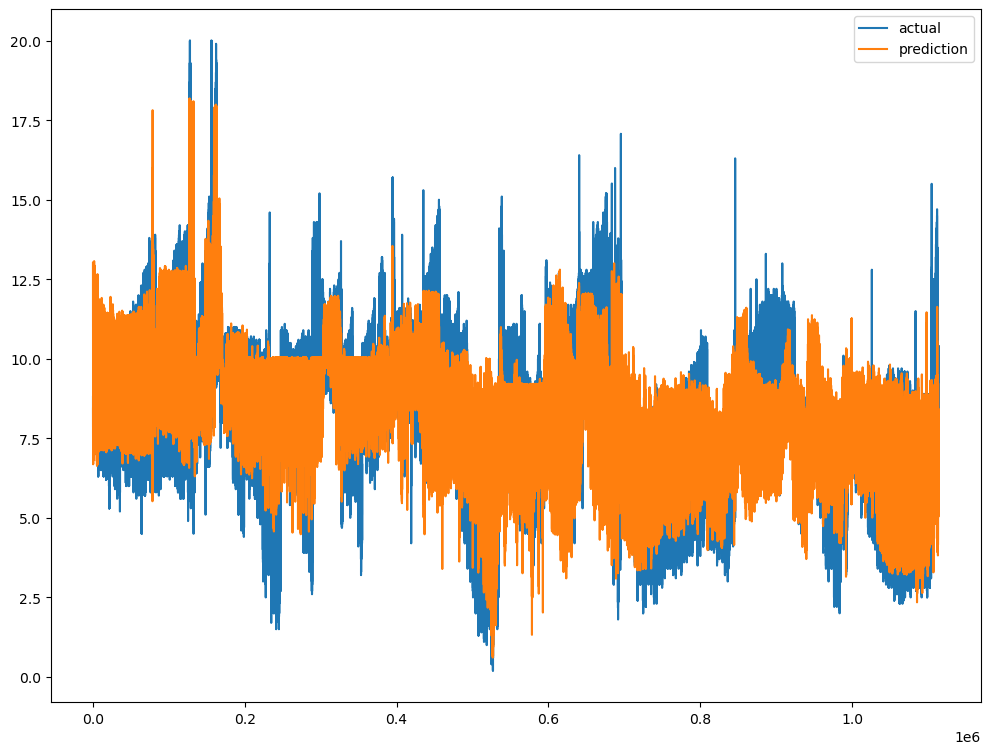

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))
plt.plot(y_test, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()
 

[[ 9.6799366e-02 -8.3527245e-02  2.5347990e-01 ...  5.1817614e-01
   2.3881859e-01 -3.2155845e-02]
 [ 8.9479826e-02 -1.1740977e-01  1.3465255e-01 ... -1.8023523e+00
   4.7720829e-01 -5.8612183e-02]
 [-1.5586770e-01 -1.2918590e-01 -9.2562295e-02 ... -1.7757140e-01
   2.1389318e-01  1.4787911e-01]
 ...
 [ 5.2274726e-02  5.3534687e-02 -1.3439894e-01 ...  1.2561208e+00
  -1.2582642e+00  3.7549775e-02]
 [-4.1401003e-02  7.0530564e-02  5.7037956e-01 ...  9.0513743e-02
   9.2361170e-01 -7.2482735e-02]
 [ 4.7914438e-02  9.6241802e-02  4.9958873e-01 ... -2.2283639e-01
   8.8929904e-01 -5.6683936e-04]]


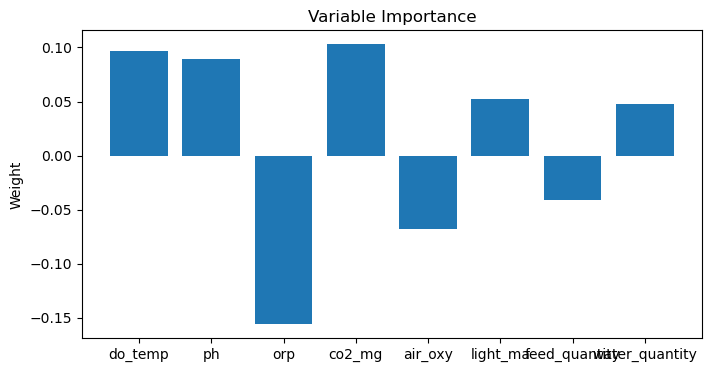

In [18]:
weights = model.layers[0].get_weights()[0]
print(weights)

import matplotlib.pyplot as plt

# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(8), weights[:, 0])
ax.set_xticks(range(8))
ax.set_xticklabels(['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [19]:
from keras.metrics import mean_squared_error, mean_absolute_error

# 평가
mse = model.evaluate(x_test, y_test)
#mae = model.evaluate(x_test, y_test, metrics=[mean_absolute_error])

print("MSE: ", mse)
#print("MAE: ", mae)

34805/34805 [==============================] - 66s 2ms/step - loss: 1.9851
MSE:  1.9851207733154297


In [20]:
oneday = validation_oneday[(validation_oneday['mea_dt'].str.contains('2021-07-21'))&(validation_oneday['tank_id']==1)]
#oneday = validation_oneday[(validation.loc[:'2021-08-09 16:3'])&(validation['tank_id']==1)]
oneday = oneday.fillna(0)
x_test_oneday = oneday[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
y_test_oneday = oneday[['do_mg']]

x_test_oneday = np.asarray(x_test_oneday, dtype=np.float64)
x_test_oneday = x_test_oneday.reshape((-1, 1, 8))

# shape확인
nCar = x_test_oneday.shape[0] # 데이터 개수
nVar = x_test_oneday.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_oneday.shape[0] # 데이터 개수
nVar = y_test_oneday.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1440 nVar: 1
nCar: 1440 nVar: 1


45/45 [==============================] - 0s 3ms/step


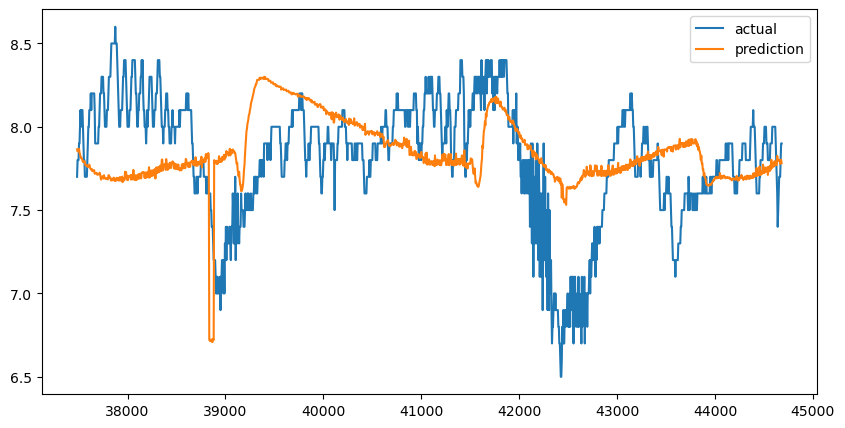

In [21]:
pred_oneday = model.predict(x_test_oneday)
plt.figure(figsize=(10, 5))
plt.plot(oneday.index, y_test_oneday, label = 'actual')
plt.plot(oneday.index, pred_oneday, label = 'prediction')
plt.legend()
plt.show()